# TG-VAE: TableGraph Variational Auto-Encoder

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch_geometric.utils import train_test_split_edges
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)


%matplotlib inline

In [2]:
os.chdir("..")

In [3]:
from utils.table2graph import create_corpus, shuffle_vocabulary, build_graph_edges, build_node_features
from utils.vectorize import generate_table_vectors
from utils.evaluation import evaluate_model
from utils.plots import plot_compound_loss,plot_single_table_relative_vectors,plot_table_vectors


## 0) Dataset loading & Model Configuration

In [4]:
dataset_path="./datasets/benchmarks/rossman50.pickle"

In [5]:
dataset= pickle.load(open(dataset_path,"rb"))

### General settings:

In [6]:
CONF = {
    "add_attr":True,
    "shuffle_vocab": True,
    "add_columns":False,
    "vector_size":16,
    "row_edges_sample":1.0,
    "column_edges_sample":0.1,
    "epoch_num":5
}

## 1) Build Table graph

### Tables tokenization

In [7]:
tokenized_tables, vocabulary, cell_dict, reversed_dictionary = corpus_tuple = create_corpus(dataset,include_attr=CONF["add_attr"])

In [8]:
if CONF["shuffle_vocab"] == True:
    shuffled_vocab = shuffle_vocabulary(vocabulary)
else:
    shuffled_vocab = None

In [9]:
nodes = build_node_features(vocabulary)
row_edges_index, row_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=CONF["row_edges_sample"],columns=False)
col_edges_index, col_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=CONF["column_edges_sample"],columns=True)

In [10]:
all_row_edges_index, all_row_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=1.0,columns=False)
all_col_edges_index, all_col_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=1.0,columns=True)

In [11]:
all_possible_edges= torch.cat((all_row_edges_index,all_col_edges_index),dim=1)

In [12]:
edges = torch.cat((row_edges_index,col_edges_index),dim=1)
weights= torch.cat((row_edges_weights,col_edges_weights),dim=0)
graph_data = Data(x=nodes,edge_index=edges,edge_attr=weights)

## 2 ) Run Table Auto-Encoder Model:

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
#x, train_pos_edge_index = split_edges(graph_data)
x, train_pos_edge_index = nodes,edges

In [15]:
EPS = 1e-15
MAX_LOGVAR = 10

class TVGAE(GAE):
    def __init__(self, encoder, decoder=None):
        super(TVGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logvar):
        if self.training:
            return mu + torch.randn_like(logvar) * torch.exp(logvar)
        else:
            return mu


    def encode(self, *args, **kwargs):
        """"""
        self.__rmu__, self.__rlogvar__,self.__cmu__, self.__clogvar__ = self.encoder(*args, **kwargs)
        self.__rlogvar__ = self.__rlogvar__.clamp(max=MAX_LOGVAR)
        self.__clogvar__ = self.__clogvar__.clamp(max=MAX_LOGVAR)
        zr = self.reparametrize(self.__rmu__, self.__rlogvar__)
        zc = self.reparametrize(self.__cmu__, self.__clogvar__)
        z=torch.cat((zr,zc),0)
        return z


    def kl_loss(self):
        rmu = self.__rmu__ 
        rlogvar = self.__rlogvar__ 

        cmu = self.__cmu__ 
        clogvar = self.__clogvar__ 
        
        rkl= -0.5 * torch.mean(
            torch.sum(1 + rlogvar - rmu**2 - rlogvar.exp(), dim=1))
        ckl= -0.5 * torch.mean(
            torch.sum(1 + clogvar - rmu**2 - clogvar.exp(), dim=1))
        return(rkl,ckl)

        
    def recon_loss(self,z, pos_edge_index,all_possible_edges):
        EPS = 1e-15
        MAX_LOGVAR = 10

        pos_loss = -torch.log(
            model.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)

        neg_edge_index = negative_sampling(all_possible_edges, z.size(0))
        neg_loss = -torch.log(1 -
                              model.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv_rows = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_cols = GCNConv(in_channels, 2 * out_channels, cached=True)
        
        self.conv_rmu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_rlogvar = GCNConv(2 * out_channels, out_channels, cached=True)

        self.conv_cmu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_clogvar = GCNConv(2 * out_channels, out_channels, cached=True)
             
        
    def forward(self, x, row_edge_index,col_edge_index):
        xr = F.relu(self.conv_rows(x, row_edge_index))
        xc = F.relu(self.conv_cols(x, col_edge_index))
        return self.conv_rmu(xr, row_edge_index),\
            self.conv_rlogvar(xr, row_edge_index),\
            self.conv_cmu(xc, col_edge_index),\
            self.conv_clogvar(xc, col_edge_index)
    
            
        


### Initialize the model

In [16]:
enc = Encoder(graph_data.num_features, CONF["vector_size"])
model = TVGAE(enc)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
def train(model,optimizer,x, row_edges,col_edges):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, row_edges,col_edges)
    mid = int(len(z)/2)
    zr=z[:mid]
    zc=z[mid:]
    
    #recon loss:
    rrl = model.recon_loss(zr,row_edges,all_possible_edges)
    crl = model.recon_loss(zc,col_edges,all_possible_edges)
    
    #kl_loss:
    rkl,ckl = model.kl_loss()

    #final loss:
    loss = rrl+crl+rkl+ckl
    
    loss.backward()
    optimizer.step()
    return loss,rrl,crl,rkl,ckl

def get_cell_vectors(model,x,row_edges_index,col_edges_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, row_edges_index,col_edges_index)
        cell_vectors = z.numpy()
    return z,cell_vectors




### Training loop:

In [19]:
losses=[]
for epoch in range(CONF["epoch_num"]):
    loss = train(model,optimizer,x,row_edges_index,col_edges_index)
    losses.append(loss)
    print(epoch,loss)

0 (tensor(14.4851, grad_fn=<AddBackward0>), tensor(10.3986, grad_fn=<AddBackward0>), tensor(3.4327, grad_fn=<AddBackward0>), tensor(0.4331, grad_fn=<MulBackward0>), tensor(0.2207, grad_fn=<MulBackward0>))
1 (tensor(11.5029, grad_fn=<AddBackward0>), tensor(7.7799, grad_fn=<AddBackward0>), tensor(3.1812, grad_fn=<AddBackward0>), tensor(0.3279, grad_fn=<MulBackward0>), tensor(0.2139, grad_fn=<MulBackward0>))
2 (tensor(8.7602, grad_fn=<AddBackward0>), tensor(5.2232, grad_fn=<AddBackward0>), tensor(3.0010, grad_fn=<AddBackward0>), tensor(0.2854, grad_fn=<MulBackward0>), tensor(0.2507, grad_fn=<MulBackward0>))
3 (tensor(7.3654, grad_fn=<AddBackward0>), tensor(3.9855, grad_fn=<AddBackward0>), tensor(2.8032, grad_fn=<AddBackward0>), tensor(0.2731, grad_fn=<MulBackward0>), tensor(0.3037, grad_fn=<MulBackward0>))
4 (tensor(6.6922, grad_fn=<AddBackward0>), tensor(3.4186, grad_fn=<AddBackward0>), tensor(2.6625, grad_fn=<AddBackward0>), tensor(0.2643, grad_fn=<MulBackward0>), tensor(0.3467, grad_fn

### 3) Extract the latent cell vectors, generate table vectors:

In [27]:
def get_cell_vectors(model,x,row_edges_index,col_edges_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, row_edges_index,col_edges_index)
        cell_vectors = z.numpy()
    return z,cell_vectors


In [28]:
z,cell_vectors = get_cell_vectors(model,x,row_edges_index,col_edges_index)
vec_list=generate_table_vectors(cell_vectors,tokenized_tables,s_vocab=shuffled_vocab)
result_score=evaluate_model(dataset,vec_list,k=5)

## 3) Evaluate the model

In [29]:
result_score=evaluate_model(dataset,vec_list,k=5)

In [30]:
result_score

0.805

# 4) Draw Plots:

## 4.1 Learning Convergence

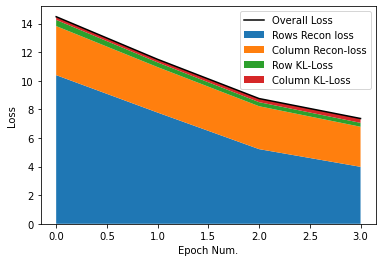

In [31]:
plot_compound_loss(losses)

## 4.2 Plot Cell vectors of a single table

In [32]:
table=tokenized_tables[10]

In [34]:
columns=dataset[0]["table"].columns
labels=np.array(columns)

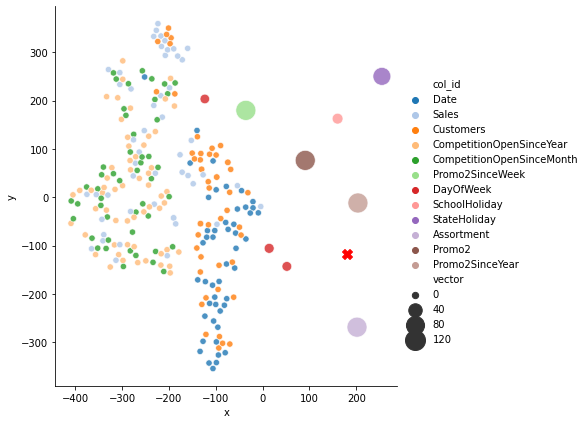

In [35]:
plot_single_table_relative_vectors(table,cell_vectors,s_vocab=shuffled_vocab,labels=labels,sample=0.5)

## 4.3 Plot Table Vectors

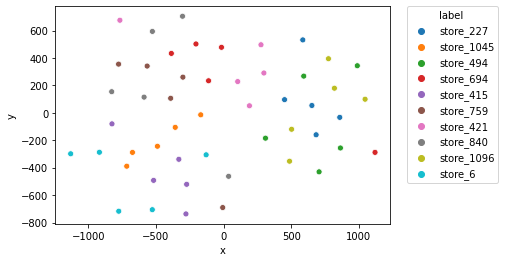

In [37]:
plot_table_vectors(vec_list,dataset)